In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357273 sha256=f318b749612c48f4989d7f3c85914f6667ac8be1ab4854254b9a528d67eb02b0
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [21]:
# Import libraries
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate

# Upload datasets
movies_file = "/content/drive/MyDrive/movies.csv"
ratings_file = "/content/drive/MyDrive/ratings_cleaned.csv"
# Load datasets
movies = pd.read_csv(movies_file)
ratings = pd.read_csv(ratings_file)

In [ ]:
print("Movies Dataset:")
print(movies.head())
print("\nRatings Dataset:")
print(ratings.head())

Movies Dataset:
   movieId                         title  \
0    42594       Scream and Scream Again   
1   280133                         Jenny   
2   225155      The Adventures of Gerard   
3    85255      ...tick...tick...tick...   
4   117999  Last of the Mobile Hot Shots   

                                       cast_and_crew  year  \
0  Gordon Hessler (director); Christopher Wicking...  1970   
1  George Bloomfield (director/screenplay); Marti...  1970   
2  Jerzy Skolimowski (director/screenplay); Arthu...  1970   
3  Ralph Nelson (director); James Lee Barrett (sc...  1970   
4  Sidney Lumet (director); Gore Vidal (screenpla...  1970   

                        poster_path                     genre  
0  /49m9QJ2ubKuVtdDj9B7XqgCyriv.jpg   Horror, Science Fiction  
1  /iaJ0PyRh17KoMcUlXxTVu6Vi85s.jpg            Drama, Romance  
2  /aoOV7vWvGiNjaUTHCSIEAeHSvOw.jpg  Adventure, Comedy, Drama  
3  /rBNgytHXZEXgOl805pYWKiBQe7s.jpg             Drama, Action  
4  /xj5Rub6H5B9yMh6GL3oomO

In [ ]:
movies.drop(columns=['poster_path'], inplace=True)

In [ ]:
# Ensure the required columns are present
assert {'userId', 'movieId', 'rating'}.issubset(ratings.columns), "Ratings file must contain 'userId', 'movieId', 'rating'."
assert {'movieId', 'title'}.issubset(movies.columns), "Movies file must contain 'movieId' and 'title'."
# Define the Reader for Surprise (rating scale should match the dataset)
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

# Load the data into Surprise's Dataset format
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD (Singular Value Decomposition) model
model = SVD()
model.fit(trainset)


In [ ]:
# Evaluate the model
print("\nModel Evaluation Results:")
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Model Evaluation Results:
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.0799  2.0229  2.0416  2.0457  2.0706  2.0522  0.0206  
MAE (testset)     1.5955  1.5616  1.5768  1.5585  1.5846  1.5754  0.0139  
Fit time          0.25    0.23    0.22    0.23    0.23    0.23    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([2.07994405, 2.02287764, 2.04163993, 2.04572788, 2.07062193]),
 'test_mae': array([1.59546081, 1.56161031, 1.57677305, 1.55851304, 1.58462577]),
 'fit_time': (0.25319766998291016,
  0.22903895378112793,
  0.2235558032989502,
  0.22930431365966797,
  0.22967958450317383),
 'test_time': (0.010662317276000977,
  0.010432243347167969,
  0.010432004928588867,
  0.010371923446655273,
  0.01098179817199707)}

In [ ]:
# Function to get movie recommendations for a user
def get_recommendations(user_id, model, movies, ratings, top_n=10):
    """
    Generate top N movie recommendations for a given user.
    """
    # Get all movies the user has already rated
    user_rated_movies = ratings[ratings['userId'] == user_id]['movieId']

    # Find unrated movies
    unrated_movies = movies[~movies['movieId'].isin(user_rated_movies)]

    # Predict ratings for all unrated movies
    recommendations = []
    for movie_id in unrated_movies['movieId']:
        prediction = model.predict(user_id, movie_id)
        recommendations.append((movie_id, prediction.est))

    # Sort by estimated rating in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_recommendations = recommendations[:top_n]

    # Display recommended movies with titles
    print(f"\nTop {top_n} Movie Recommendations for User {user_id}:")
    for movie_id, predicted_rating in top_recommendations:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f"{movie_title} (Predicted Rating: {predicted_rating:.2f})")

In [ ]:
# Get recommendations for a specific user
user_id = 2  # Replace this with the desired userId
get_recommendations(user_id, model, movies, ratings, top_n=10)


Top 10 Movie Recommendations for User 2:
Top Gun: Maverick (Predicted Rating: 8.02)
Interstellar (Predicted Rating: 7.95)
Joker (Predicted Rating: 7.94)
Spider-Man: No Way Home (Predicted Rating: 7.90)
The Lighthouse (Predicted Rating: 7.73)
Blade Runner (Predicted Rating: 7.68)
Terminator 2: Judgment Day (Predicted Rating: 7.67)
Guardians of the Galaxy (Predicted Rating: 7.64)
Die Hard (Predicted Rating: 7.63)
The Empire Strikes Back (Predicted Rating: 7.63)


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define a threshold for "liked" movies (e.g., ratings >= 4)
threshold = 4

# Generate predictions for the test set
predictions = [model.predict(uid, iid).est for (uid, iid, true_r) in testset]
true_labels = [1 if true_r >= threshold else 0 for (_, _, true_r) in testset]
predicted_labels = [1 if pred >= threshold else 0 for pred in predictions]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predictions)

# Display the metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")



Evaluation Metrics:
Accuracy: 0.91
Precision: 0.91
Recall: 1.00
F1 Score: 0.95
ROC AUC: 0.92


In [39]:
# Convert ratings into binary labels (e.g., liked vs. not liked)
ratings['liked'] = ratings['rating'].apply(lambda x: 1 if x >= 4 else 0)


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Merge the ratings and movies data
data = pd.merge(ratings, movies[['movieId', 'title']], on='movieId')

# Split into features (userId, movieId) and target (liked)
X = data[['userId', 'movieId']]
y = data['liked']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine (SVM)
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate models with precision, recall, and F1 score
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation metrics for {model_name}:")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print("-" * 50)

# Evaluate each model
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_knn, "K-Nearest Neighbors")
evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")


Evaluation metrics for Random Forest:
Precision: 0.9290322580645162
Recall: 0.9376744186046512
F1 Score: 0.9333333333333333
Accuracy: 0.8766595289079229
--------------------------------------------------
Evaluation metrics for SVM:
Precision: 0.9207708779443254
Recall: 1.0
F1 Score: 0.9587513935340022
Accuracy: 0.9207708779443254
--------------------------------------------------
Evaluation metrics for K-Nearest Neighbors:
Precision: 0.9202081526452732
Recall: 0.9869767441860465
F1 Score: 0.952423698384201
Accuracy: 0.9092077087794432
--------------------------------------------------
Evaluation metrics for Logistic Regression:
Precision: 0.9207708779443254
Recall: 1.0
F1 Score: 0.9587513935340022
Accuracy: 0.9207708779443254
--------------------------------------------------


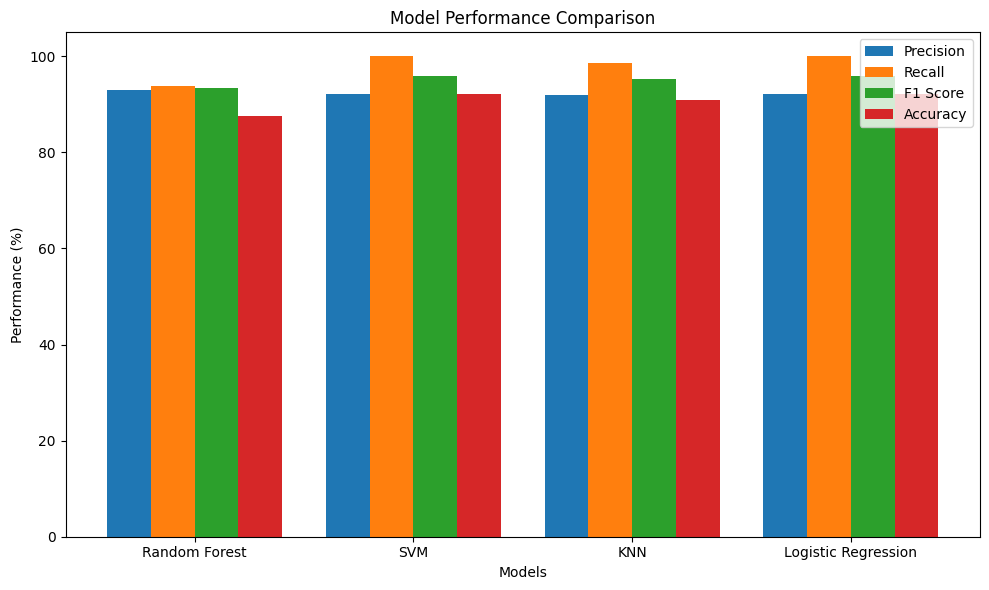

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Random Forest', 'SVM', 'KNN', 'Logistic Regression']
precision = [92.90, 92.08, 92.02, 92.08]
recall = [93.77, 100.00, 98.70, 100.00]
f1_score = [93.33, 95.88, 95.24, 95.88]
accuracy = [87.67, 92.08, 90.92, 92.08]

# Create a bar plot for each metric
bar_width = 0.2
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x - 1.5*bar_width, precision, bar_width, label='Precision')
bar2 = ax.bar(x - 0.5*bar_width, recall, bar_width, label='Recall')
bar3 = ax.bar(x + 0.5*bar_width, f1_score, bar_width, label='F1 Score')
bar4 = ax.bar(x + 1.5*bar_width, accuracy, bar_width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Performance (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


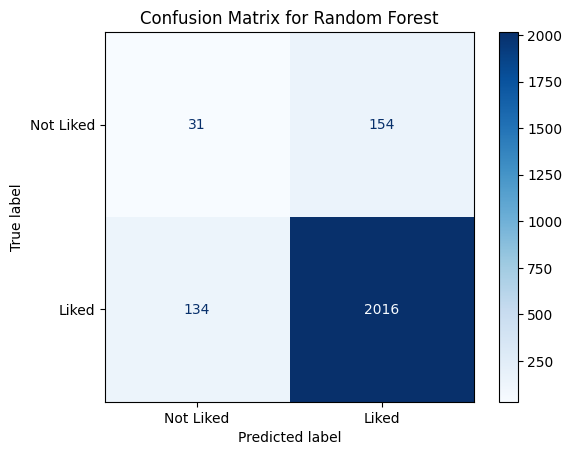

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the true labels (y_test) and predictions (y_pred_rf)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Liked', 'Liked'])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.show()


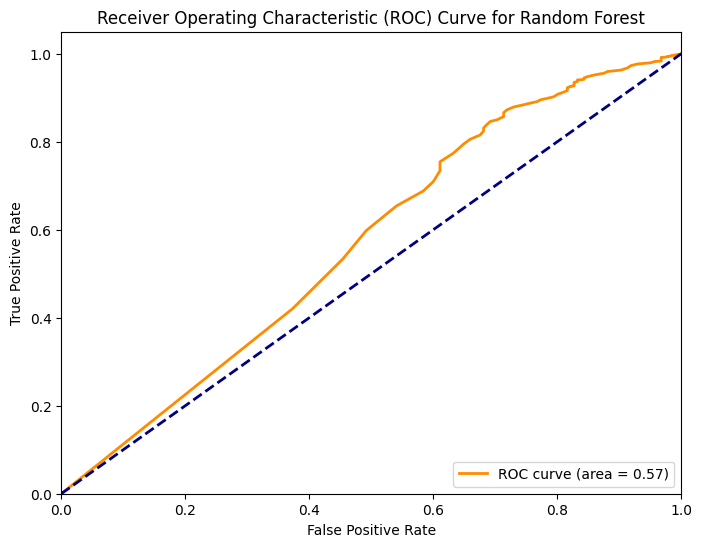

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have the true labels (y_test) and the predictions from the model
# For Random Forest, use the predict_proba() method to get the probabilities
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # Get the probability of class '1' (liked)

# Now calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)  # fpr: false positive rate, tpr: true positive rate
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()
